In [ ]:
import tensorflow as tf
import keras

Генерация текста Шекспира, с использованием RNN

In [ ]:
shakspeare_url = "https://homl.info/shakespeare"
filepath = keras.utils.get_file("shekespeare.txt", shakspeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
print(tokenizer.texts_to_sequences(['First']))
print(tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]]))
max_id = len(tokenizer.word_index) # количество несовпадающих символов
dataset_size = tokenizer.document_count # общее число символов

[[20, 6, 9, 8, 3]]
['f i r s t']


Получение идентификаторов от 0 до 38, -1 - чтобы уйти от 1 до 39

In [ ]:
import numpy as np

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [ ]:
train_size = dataset_size * 90 // 100 # 90% выборки
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
n_steps = 100
window_length = n_steps + 1 # вход, сдвинутый на 1 символ вперед
dataset = dataset.window(window_length, shift=1, drop_remainder=True) # окно смещается на 1, drop_remainder не уменьшает выборку с каждой итерацией

Разобьет по последовательностям, например:

lambda ds: ds.batch(2)

{{1,2}, {3,4,5,6}} -> {[1,2],[3,4],[5,6]}

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [ ]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)

In [ ]:
dataset = dataset.prefetch(1)

In [ ]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

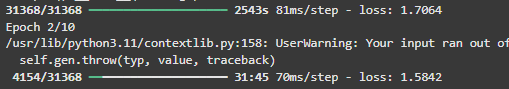

In [ ]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

'u'

Генерирование текста Шекспира

In [ ]:
def next_char(text, temperature=1):
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

print("temperature=0.2\n", complete_text('t', temperature=0.2))
print("temperature=1\n", complete_text('w', temperature=1))
print("temperature=2\n", complete_text('w', temperature=2))

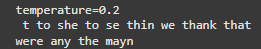

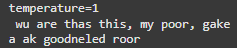


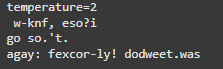

# Stateful RNN (RNN с сохранением состояния)

In [ ]:
tf.random.set_seed(42)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=50,
                    callbacks=[ResetStatesCallback()])

In [ ]:
(X_train, y_train), (X_text, y_test) = keras.datasets.imdb.load_data()
X_train[0][:10]

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'